<a href="https://colab.research.google.com/github/ChitandaMayaka/CMPE255-Team-Project/blob/main/TrainingAndEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training, Evaluation and Comparison
1. Models:
  - Linear Regression(baseline)
  - Support Vector Machines
  - Random Forest 
  - XGBoost
  - LightGBM
2. Evaluation: 
  RMSE for target variables(Price), for cross validation, we use default 5 fold(cv=5).
3. Comparision:
  Compare the training time, CV RMSE, Training RMSE and Test RMSE for different models


## Load data

In [ ]:
import numpy as np
import pandas as pd
import requests
from time import time

In [ ]:
# Load data
def load_dataset(fn, url):
    URL = url
    filename = fn
    request = requests.get(URL)
    file = open(filename, 'wb')
    file.write(request.content)

In [ ]:
load_dataset('x_train.csv', 'https://raw.githubusercontent.com/ChitandaMayaka/CMPE255-Team-Project/main/dataset/x_train.csv')
load_dataset('x_test.csv', 'https://raw.githubusercontent.com/ChitandaMayaka/CMPE255-Team-Project/main/dataset/x_test.csv')
load_dataset('y_train.csv', 'https://raw.githubusercontent.com/ChitandaMayaka/CMPE255-Team-Project/main/dataset/y_train.csv')
load_dataset('y_test.csv', 'https://raw.githubusercontent.com/ChitandaMayaka/CMPE255-Team-Project/main/dataset/y_test.csv')

In [ ]:
X_train = pd.read_csv('x_train.csv')
X_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [ ]:
# import evaluation metrics and cross validation, grid search
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

In [ ]:
def getRMSE(y_true, y_pred):
  return (mean_squared_error(y_true, y_pred))**0.5

In [ ]:
# dictionary to store all the result from different models
# result example: {"Linear regression: {training_time, cv_rmse, train_rmse, test_rmse}"}
results = {}

## Linear Regression(Baseline)

In [ ]:
# use linear regression as a basic model for baseline
from sklearn.linear_model import LinearRegression

In [ ]:
linreg = LinearRegression()
linreg_cv_rmse = -cross_val_score(linreg, X_train, y_train, scoring='neg_root_mean_squared_error').mean()
start_t = time()
linreg.fit(X_train, y_train)
linreg_training_time = time() - start_t
linreg_y_pred_train = linreg.predict(X_train)  
linreg_y_pred_test = linreg.predict(X_test)
linreg_rmse_train = getRMSE(y_train, linreg_y_pred_train)
linreg_rmse_test = getRMSE(y_test, linreg_y_pred_test)
linreg_r2_train = r2_score(y_train, linreg_y_pred_train)
linreg_r2_test = r2_score(y_test, linreg_y_pred_test)
linreg_result = {"training_time":linreg_training_time, 
                 "cv_rmse":linreg_cv_rmse, 
                 "train_rmse":linreg_rmse_train, 
                 "test_rmse":linreg_rmse_test,
                 "train_r2":linreg_r2_train, 
                 "test_r2":linreg_r2_test,
                 }
results["LinearReg"] = linreg_result

In [ ]:
print("Linear Regression: {}".format(linreg_result))

Linear Regression: {'training_time': 0.02729511260986328, 'cv_rmse': 8783.593741764049, 'train_rmse': 8769.258643615587, 'test_rmse': 8908.23874588955, 'train_r2': 0.41518502942025926, 'test_r2': 0.3993815949713295}


## Support Vector Machines

In [ ]:
from sklearn.svm import SVR

### Hyperparameter Search

In [ ]:
svr_param_grid = {
    'kernel' : ['poly'],
    'C' : [100],
    'gamma' : ['scale'],
    # 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    # 'C' : [5, 10, 30, 70, 100],
    # 'gamma' : ['auto','scale'],
    # Parameters for gird search are as above: 
    # It takes about 6 hours to finish this grid search
    # to save time running this notebook for review only keep the best parameters combinations here
    }

In [ ]:
svr_gs = GridSearchCV(SVR(), svr_param_grid, scoring='neg_root_mean_squared_error')
svr_gs.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100], 'gamma': ['scale'], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [ ]:
svr_cv_rmse = -svr_gs.best_score_
svr_best_params = svr_gs.best_params_
print("CV RMSE:{}, Best prameters:{}".format(svr_cv_rmse, svr_best_params))

CV RMSE:7467.893744608108, Best prameters:{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


### Best Parameters Model

In [ ]:
# train and test model with best parameters
svr_best_params = {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
svr = SVR(**svr_best_params)
svr_cv_rmse = -cross_val_score(svr, X_train, y_train.values.ravel(), scoring='neg_root_mean_squared_error').mean()
start_t = time()
svr.fit(X_train, y_train.values.ravel())
svr_training_time = time() - start_t
svr_y_pred_train = svr.predict(X_train)  
svr_y_pred_test = svr.predict(X_test)
svr_rmse_train = getRMSE(y_train, svr_y_pred_train)
svr_rmse_test = getRMSE(y_test, svr_y_pred_test)
svr_r2_train = r2_score(y_train, svr_y_pred_train)
svr_r2_test = r2_score(y_test, svr_y_pred_test)
svr_result = {"training_time":svr_training_time, 
                 "cv_rmse":svr_cv_rmse, 
                 "train_rmse":svr_rmse_train, 
                 "test_rmse":svr_rmse_test,
                 "train_r2":svr_r2_train, 
                 "test_r2":svr_r2_test,
                 }
results["SVR"] = svr_result

In [ ]:
print("Support Vector Regression: {}".format(svr_result))

Support Vector Regression: {'training_time': 230.37623810768127, 'cv_rmse': 7467.893744608108, 'train_rmse': 7429.521080679628, 'test_rmse': 7707.180509009851, 'train_r2': 0.5802271352825319, 'test_r2': 0.550421015535743}


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Hyperparameter Search

In [ ]:
'''rf_params = {'n_estimators': [100, 300, 500, 700], 
             'max_depth': [4, 5, 6, 7], 
             'bootstrap': [True, False], 
             'max_samples': [0.7, 0.8, 0.9]}'''

In [ ]:
'''rf_rs = RandomizedSearchCV(RandomForestRegressor(), rf_params, scoring='neg_root_mean_squared_error')
rf_rs.fit(X_train, y_train.values.ravel())'''

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [ ]:
'''rf_rs_rmse = -rf_rs.best_score_
rf_best_params = rf_rs.best_params_
print("RS RMSE:{}, Best prameters:{}".format(rf_rs_rmse, rf_best_params))'''

RS RMSE:6685.154842398678, Best prameters:{'n_estimators': 700, 'max_samples': 0.8, 'max_depth': 6, 'bootstrap': True}


### Best parameters model

In [ ]:
# train and test model with best parameters
rf_best_params = {'n_estimators': 700, 'max_samples': 0.8, 'max_depth': 6, 'bootstrap': True}
rf_reg = RandomForestRegressor(**rf_best_params)
rf_cv_rmse = -cross_val_score(rf_reg, X_train, y_train.values.ravel(), scoring='neg_root_mean_squared_error').mean()
start_time = time()
rf_reg.fit(X_train, y_train.values.ravel())
rf_training_time = time() - start_time
rf_y_pred_train = rf_reg.predict(X_train)  
rf_y_pred_test = rf_reg.predict(X_test)
rf_rmse_train = getRMSE(y_train, rf_y_pred_train)
rf_rmse_test = getRMSE(y_test, rf_y_pred_test)
rf_r2_train = r2_score(y_train, rf_y_pred_train)
rf_r2_test = r2_score(y_test, rf_y_pred_test)
rf_result = {"training_time":rf_training_time, 
                 "cv_rmse":rf_cv_rmse, 
                 "train_rmse":rf_rmse_train, 
                 "test_rmse":rf_rmse_test,
                 "train_r2":rf_r2_train, 
                 "test_r2":rf_r2_test,
                 }
results["RandomForest"] = rf_result

In [ ]:
print("RandomForest Regression: {}".format(rf_result))

RandomForest Regression: {'training_time': 57.13866472244263, 'cv_rmse': 6687.823770456083, 'train_rmse': 6561.330977071405, 'test_rmse': 7140.467409394849, 'train_r2': 0.6726015538595189, 'test_r2': 0.6141058248436999}


## XGBoost

In [ ]:
import xgboost as xgb
import sklearn as sk

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)

### Model before tuning

In [ ]:
param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'reg:linear' }
num_round = 2

bst_start_time = time()
bst = xgb.train(param, dtrain, num_round)
bst_training_time = time() - bst_start_time

train_preds = bst.predict(dtrain)
train_preds

[12:52:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([ 5452.134, 17377.738,  9775.979, ...,  9775.979, 32760.48 ,
        9775.979], dtype=float32)

In [ ]:
test_preds = bst.predict(dtest)

In [ ]:
bst_rmse_train = getRMSE(y_train, train_preds)
bst_rmse_test = getRMSE(y_test, test_preds)
bst_r2_train = r2_score(y_train, train_preds)
bst_r2_test = r2_score(y_test, test_preds)
bst_result = {"training_time":bst_training_time, 
                 "train_rmse":bst_rmse_train, 
                 "test_rmse":bst_rmse_test,
                 "train_r2":bst_r2_train, 
                 "test_r2":bst_r2_test,
                 }

In [ ]:
print("XGBoost: {}".format(bst_result))

XGBoost: {'training_time': 0.06515312194824219, 'train_rmse': 7960.619037084481, 'test_rmse': 8251.364176720701, 'train_r2': 0.5180672897358982, 'test_r2': 0.48469251451263273}


### Hyperparameter Search

In [ ]:
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)}
xgbr = xgb.XGBRegressor(**param)
gs = GridSearchCV(xgbr, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)  

print("best value：:", gs.best_params_)
print("best score:", gs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.8min finished


[13:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best value：: {'n_estimators': 1000}
best score: 0.7305247512296441


In [ ]:
cv_params = {'n_estimators': np.linspace(1000, 1500, 5, dtype=int)}
gs = GridSearchCV(xgbr, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)  

print("best value：:", gs.best_params_)
print("best score:", gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.9min finished


[13:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best value：: {'n_estimators': 1500}
best score: 0.7359042063074014


In [ ]:
cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)}

param = { 'eta':1, 'silent':0, 'objective':'reg:linear', 'n_estimators':1500}
xgbr = xgb.XGBRegressor(**param)
gs = GridSearchCV(xgbr, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)  

print("best value：:", gs.best_params_)
print("best score:", gs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 56.0min finished


[14:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best value：: {'max_depth': 8}
best score: 0.7755885852701653


In [ ]:
param = { 'eta':1, 'silent':0, 'objective':'reg:linear', 'n_estimators':1500, 'max_depth': 8}
cv_params = {'min_child_weight': np.linspace(1, 10, 10, dtype=int)}
xgbr = xgb.XGBRegressor(**param)  
gs = GridSearchCV(xgbr, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)  

print("best value：:", gs.best_params_)
print("best score:", gs.best_score_)

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 60.3min


In [ ]:
print("best value：:", gs.best_params_)
print("best score:", gs.best_score_)

best value：: {'min_child_weight': 4}
best score: 0.7763869496545771


### Best parameters model

In [ ]:
param = { 'eta':1, 'silent':0, 'objective':'reg:squarederror', 'n_estimators':1500, 'max_depth': 8, 'min_child_weight': 4}

xgb_reg = xgb.XGBRegressor(**param)
bst_start_time = time()
xgb_reg.fit(X_train, y_train)
bst_training_time = time() - bst_start_time


In [ ]:
train_preds = xgb_reg.predict(X_train)
test_preds = xgb_reg.predict(X_test)
bst_cv_rmse = -cross_val_score(xgb_reg, X_train, y_train.values.ravel(), scoring='neg_root_mean_squared_error').mean()
bst_rmse_train = getRMSE(y_train, train_preds)
bst_rmse_test = getRMSE(y_test, test_preds)
bst_r2_train = r2_score(y_train, train_preds)
bst_r2_test = r2_score(y_test, test_preds)


In [ ]:
bst_result = {"training_time":bst_training_time, 
                 "cv_rmse": bst_cv_rmse,
                 "train_rmse":bst_rmse_train, 
                 "test_rmse":bst_rmse_test,
                 "train_r2":bst_r2_train, 
                 "test_r2":bst_r2_test,
                 }
results["XGBoost"] = bst_result
print("XGBoost: {}".format(bst_result))

XGBoost: {'training_time': 125.05418682098389, 'cv_rmse': 5418.7501954753725, 'train_rmse': 2060.5979691156185, 'test_rmse': 5855.396615924981, 'train_r2': 0.9677091663405154, 'test_r2': 0.740505847732833}


## LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
train_lgb = lgb.Dataset(X_train, label=y_train)
test_lgb = lgb.Dataset(X_test, label=y_test)

### Model before tuning

In [ ]:
param = {'num_leaves':31, 'num_trees':100, 'objective':'regression'}
param['metric'] = 'rmse'
num_round = 10
lgb_start_time = time()
bst = lgb.train(param, train_lgb, num_round, valid_sets=[test_lgb])
lgb_training_time = time() - lgb_start_time

In [ ]:
lgb_pred = bst.predict(X_test)

In [ ]:
lgb_pred_train = bst.predict(X_train)

In [ ]:
lgb_rmse_train = getRMSE(y_train, lgb_pred_train)
lgb_rmse_test = getRMSE(y_test, lgb_pred)
lgb_r2_train = r2_score(y_train, lgb_pred_train)
lgb_r2_test = r2_score(y_test, lgb_pred)
lgb_result = {"training_time":lgb_training_time, 
                 "train_rmse":lgb_rmse_train, 
                 "test_rmse":lgb_rmse_test,
                 "train_r2":lgb_r2_train, 
                 "test_r2":lgb_r2_test,
                 }
print("LGB: {}".format(lgb_result))

LGB: {'training_time': 0.6779727935791016, 'train_rmse': 5320.5938137636, 'test_rmse': 6123.752129317019, 'train_r2': 0.7847154156689984, 'test_r2': 0.7161753260718169}


### Hyperparameter Search

In [ ]:
parameters = {
    'max_depth': [8,10,12,14,16],
    'num_leaves': [40,50,60,70,80],
}

In [ ]:
lgbmRegressor = lgb.LGBMRegressor(**param)
gsearch = GridSearchCV(lgbmRegressor, param_grid=parameters, scoring='r2', cv=3)

In [ ]:
gsearch.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params.

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     num_trees=100, objective='regression',
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [8, 10, 12, 14, 16],
         

In [ ]:
print('Best values:{0}'.format(gsearch.best_params_))
print('Best score:{0}'.format(gsearch.best_score_))

Best values:{'max_depth': 16, 'num_leaves': 80}
Best score:0.7599992298075859


### Best parameters model

In [ ]:
param = { 'n_estimators':1500, 'num_trees':100, 'objective':'regression', 'max_depth': 16, 'num_leaves': 80}
param['metric'] = 'rmse'
lgbm_reg = lgb.LGBMRegressor(**param)
num_round = 10
lgb_start_time = time()
lgbm_reg.fit(X_train, y_train)
lgb_training_time = time() - lgb_start_time


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
lgb_pred = lgbm_reg.predict(X_test)
lgb_cv_rmse = -cross_val_score(lgbm_reg, X_train, y_train.values.ravel(), scoring='neg_root_mean_squared_error').mean()
lgb_pred_train = lgbm_reg.predict(X_train)
lgb_rmse_train = getRMSE(y_train, lgb_pred_train)
lgb_rmse_test = getRMSE(y_test, lgb_pred)
lgb_r2_train = r2_score(y_train, lgb_pred_train)
lgb_r2_test = r2_score(y_test, lgb_pred)
lgb_result = {"training_time":lgb_training_time, 
              "cv_rmse": lgb_cv_rmse,
              "train_rmse":lgb_rmse_train, 
              "test_rmse":lgb_rmse_test,
              "train_r2":lgb_r2_train, 
              "test_r2":lgb_r2_test,
              }
results["LightGBM"] = lgb_result

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params.

In [ ]:
print("LightGBM: {}".format(lgb_result))

LightGBM: {'training_time': 0.903496265411377, 'cv_rmse': 5519.48955607348, 'train_rmse': 4796.108303197684, 'test_rmse': 5983.961682285, 'train_r2': 0.8250674263566358, 'test_r2': 0.728985486875156}


## Model Comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,training_time,cv_rmse,train_rmse,test_rmse,train_r2,test_r2
XGBoost,125.054187,5418.750195,2060.597969,5855.396616,0.967709,0.740506
LightGBM,0.852564,5642.526361,5255.073493,6088.480356,0.789985,0.719435
SVR,230.376238,7467.893745,7429.521081,7707.180509,0.580227,0.550421
RandomForest,57.138665,6687.823770,6561.330977,7140.467409,0.672602,0.614106
LinearReg,0.029039,8783.593742,8769.258644,8908.238746,0.415185,0.399382


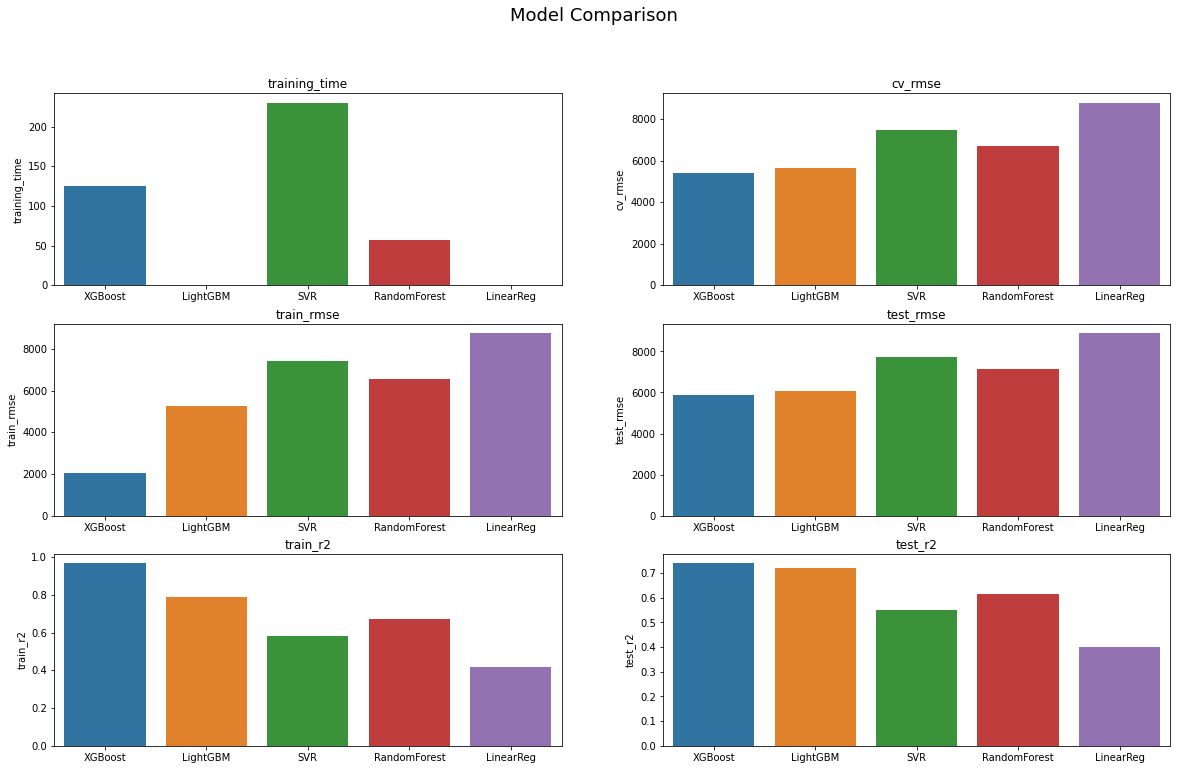

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
axes = axes.flatten()
fig.suptitle('Model Comparison', fontsize=18)
count=0
for col in results_df.columns:
  ax=axes[count]
  ax.set_title(col)
  sns.barplot(ax=ax,
              data= results_df,
              x= results_df.index,
              y= col)
  count += 1